In [83]:
import os
from zipfile import is_zipfile, ZipFile
from pickle import load
import matplotlib.pyplot as plt
from numpy import array, stack, zeros
import torch 
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn 
from torch import optim 
# from torchsummary import summary

## Unzip precoder dataset

In [84]:
dir_name = 'datasets'
if os.path.exists(dir_name):
    print("Data has already been unzipped.")
else:
    if os.path.exists('datasets.zip'):
        if is_zipfile('datasets.zip'):
            with ZipFile('datasets.zip', 'r') as zip_data_obj:
                zip_data_obj.extractall()
        else:
            print('File exists, but is not a zip archive.')
    else:
        print('datasets.zip was not found.')



Data has already been unzipped.


## Load precoder dataset

In [85]:
def load_dataset(dir_name, fading, num_ant, SNR_dB, bit_codebook):

    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    file_name = f'{dir_name}/{fading}_precoder_data_{num_ant}_ant_SNR_{SNR_dB}dB_{bit_codebook}_bit_codebk'
    print(file_name)
    with open(f'{file_name}.pkl', 'rb') as f:
        precoders, labels = load(f)
    return precoders, labels

## Visualization of Data

In [86]:
def visualize(precoders):
    # test plots
    for i in range(2):
        plt.scatter(precoders[i][0::2], precoders[i][1::2])
        plt.show()

## Precoder dataset class that packages the dataset into a format compatible with PyTorch

In [87]:
class PrecoderDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

## Neural Network Class

In [88]:

class Model(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        # define layers and activation function as class parameters
        self.fc1 = nn.Linear(in_features=input_size, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=100)
        self.output = nn.Linear(in_features=100, out_features=output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=output_size)

    def forward(self, x):
        # define NN connections here, output of last layer is pred
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        pred = self.softmax(self.output(x))
        return pred


## Essential System Parameters

In [89]:
max_iter = 100000
fading = 1
num_ant = [2, 4]
SNR_dB = [10, 20, 45]
bit_codebook = [1, 2]
visual = 0

## Training Parameters

In [90]:
learning_rate = 0.01
num_epochs = 10 # Number of times you go through the whole dataset

## Simulation iterations
1. Load dataset
2. Visualize, if necessary 
3. Create instance of precoder dataset class (Package dataset such that it is compatible for PyTorch)
4. Split dataset into 80% training and 20% validation
5. Create PyTorch dataloaders for training and validation data (Dataloaders divide the dataset into chuncks called batches. We can pass data to the neural network one batch at a time) 
6. Create an instance of neural network class
7. Define the loss and optimizer
8. Epoch - one pass of the entire dataset (training + validation)
9. In each epoch you iterate over several batches (Batch - chunk of data that is fed to the neural network in one go) 

In [91]:
validation_accuracy = zeros((len(SNR_dB), len(num_ant), len(bit_codebook), num_epochs))
validation_loss_buffer = zeros((len(SNR_dB), len(num_ant), len(bit_codebook), num_epochs))
snr_loop = 0
for SNR in SNR_dB:
    ant_loop = 0
    for ant in num_ant:
        bit_loop = 0
        for bit in bit_codebook:
            print(f'======{SNR} dB, {ant} antennas, {bit} bit codebook======')
            
            precoders, labels = load_dataset('datasets', fading, ant, SNR, bit)
            if visual == 1:
                visualize(precoders)

            precoder_data = stack(precoders, axis=0)
            precoder_labels = array(labels)    

            precoder_dataset = PrecoderDataset(precoder_data, precoder_labels)
            train, val = random_split(precoder_dataset, [int(0.8*max_iter), int(0.2*max_iter)])
            train_loader = DataLoader(train, batch_size=128, shuffle=True, num_workers=0)
            val_loader = DataLoader(val, batch_size=128, shuffle=True, num_workers=0)
            
            num_classes = 2**bit
            nn_input_size = 2*ant*ant
            nn_output_size = num_classes
            
            model = Model(nn_input_size, nn_output_size)

            if torch.cuda.is_available():
                model.cuda()

            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            loss = nn.CrossEntropyLoss()
            for epoch in range(num_epochs):

                # TRAINING
                model.train()
                training_total_correct = 0
                training_losses = list()
                for batch in train_loader:

                    x, y = batch # extracted from the batch 

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    # step 1: forward pass 
                    prob = model(x) 

                    output = prob
                    target = y

                    # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
                    obj_func = loss(output, target)

                    # step 3: clear the gradients 
                    model.zero_grad()

                    # step 4: accumulate partial derivatives of obj_func wrt parameters 
                    obj_func.backward()

                    # step 5: step in the opposite direction of the gradient 
                    optimizer.step()

                    training_losses.append(obj_func.item())

                    max_prob, max_ind = torch.max(output, 1)
                    for ind in range(len(max_ind)):
                        if torch.equal(max_ind[ind], y[ind]):
                            training_total_correct += 1    

                # VALIDATION
                model.eval()

                validation_total_correct = 0
                validation_losses = list()
                for batch in val_loader:

                    x, y = batch # extracted from the batch 

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    # step 1: forward pass 
                    with torch.no_grad():
                        prob = model(x) 

                    output = prob
                    target = y

                    # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
                    obj_func = loss(output, target)
                    validation_losses.append(obj_func.item())

                    max_prob, max_ind = torch.max(output, 1)

                    for ind in range(len(max_ind)):
                        if torch.equal(max_ind[ind], y[ind]):
                            validation_total_correct += 1
                training_accuracy = (training_total_correct/len(train))*100  
                validation_accuracy[snr_loop, ant_loop, bit_loop, epoch] = (validation_total_correct/len(val))*100
                validation_loss_buffer[snr_loop, ant_loop, bit_loop, epoch] = torch.tensor(validation_losses).mean()

                print(f'Epoch {epoch + 1}, training loss: {torch.tensor(training_losses).mean():.8f}, training accuracy: {training_accuracy}%, validation loss: {torch.tensor(validation_losses).mean():.8f}, validation accuracy: {validation_accuracy[snr_loop, ant_loop, bit_loop, epoch]}%')
            bit_loop += 1
        ant_loop += 1
    snr_loop += 1

======10 dB, 2 antennas, 1 bit codebook======
datasets/1_precoder_data_2_ant_SNR_10dB_1_bit_codebk
Epoch 1, training loss: 0.58979595, training accuracy: 92.65124999999999%, validation loss: 0.46550664, validation accuracy: 93.51%
Epoch 2, training loss: 0.41892534, training accuracy: 93.45375%, validation loss: 0.39632252, validation accuracy: 93.515%
Epoch 3, training loss: 0.39060488, training accuracy: 93.45750000000001%, validation loss: 0.38587075, validation accuracy: 93.535%
Epoch 4, training loss: 0.38439769, training accuracy: 93.44%, validation loss: 0.38253710, validation accuracy: 93.51%
Epoch 5, training loss: 0.38185155, training accuracy: 93.44749999999999%, validation loss: 0.38030520, validation accuracy: 93.52000000000001%
Epoch 6, training loss: 0.38048735, training accuracy: 93.4425%, validation loss: 0.37967551, validation accuracy: 93.51%
Epoch 7, training loss: 0.37963638, training accuracy: 93.44375000000001%, validation loss: 0.37845814, validation accuracy: 9

C:\Users\bup48\anaconda3\envs\Py37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


## Graph Results

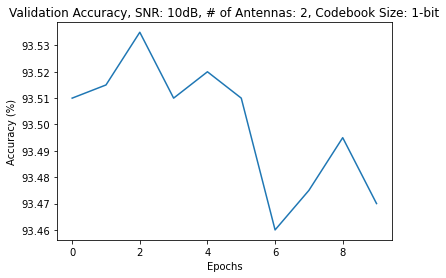

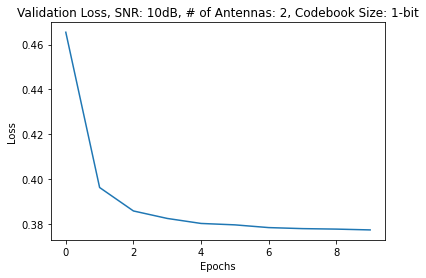

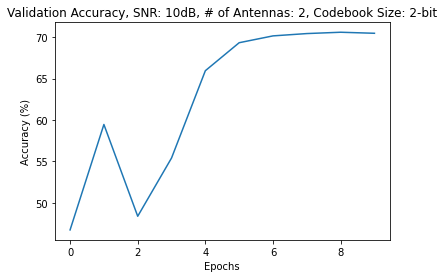

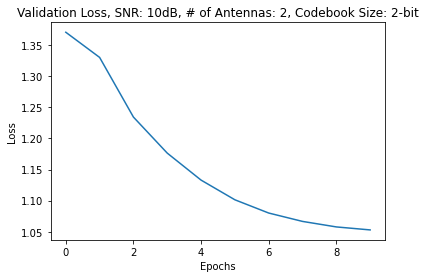

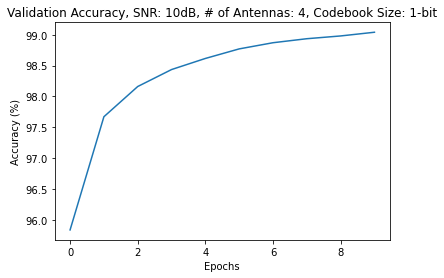

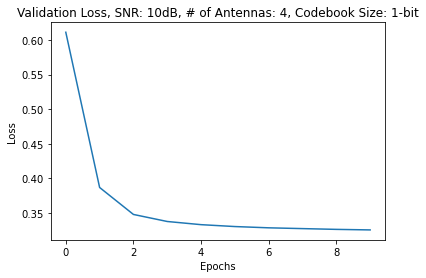

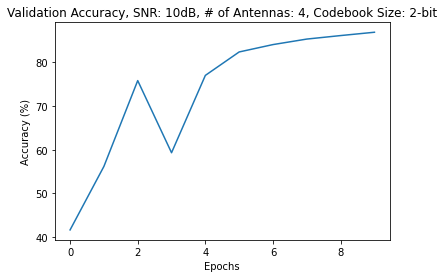

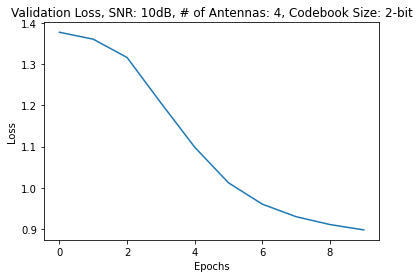

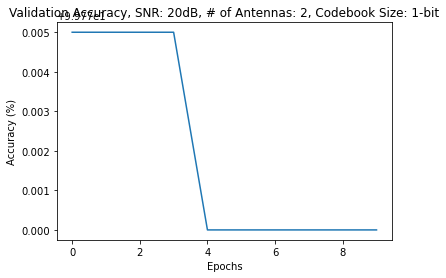

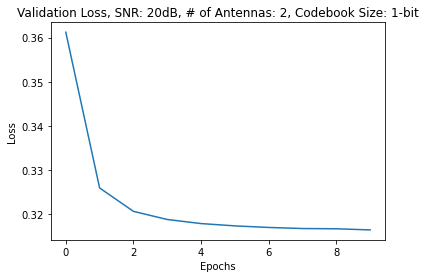

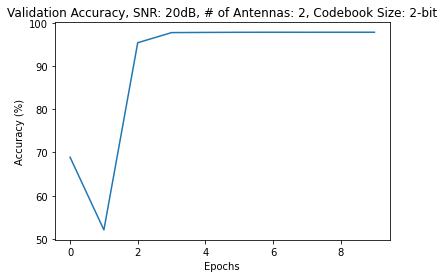

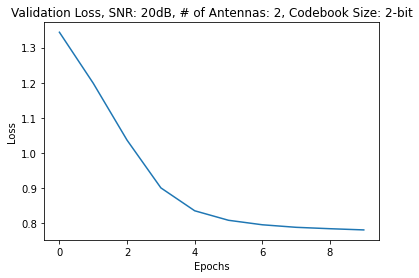

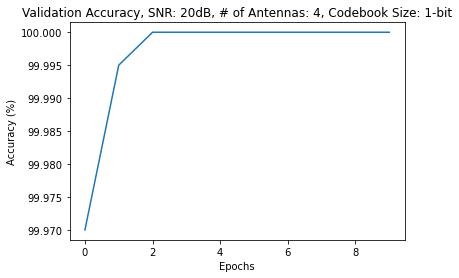

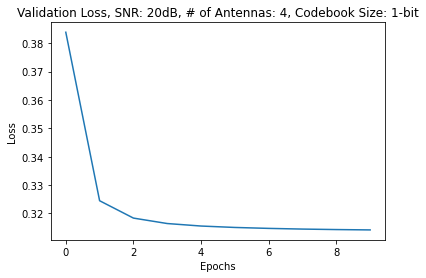

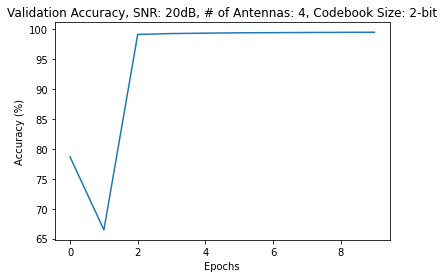

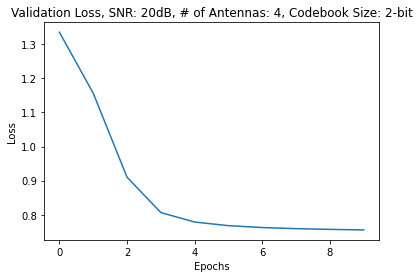

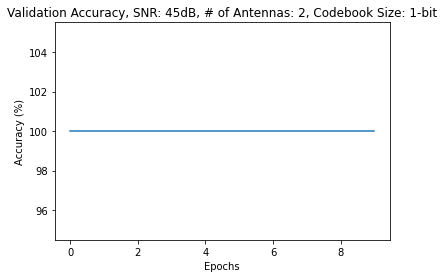

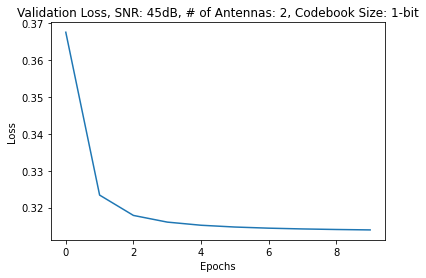

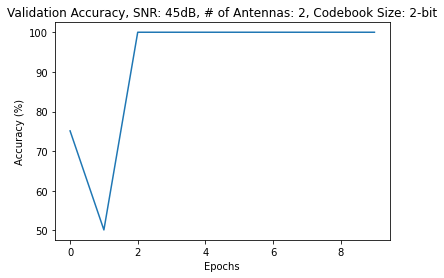

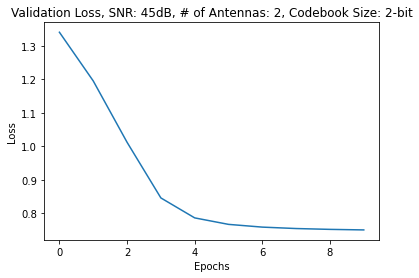

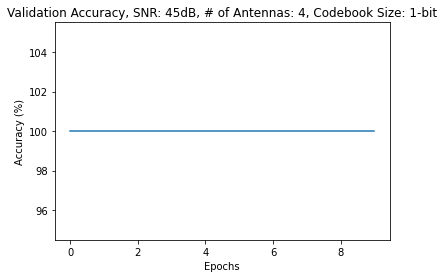

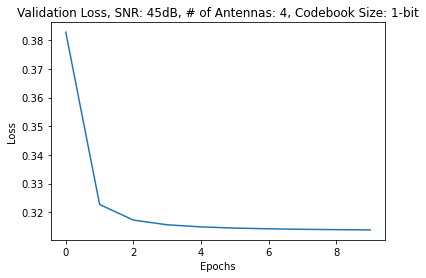

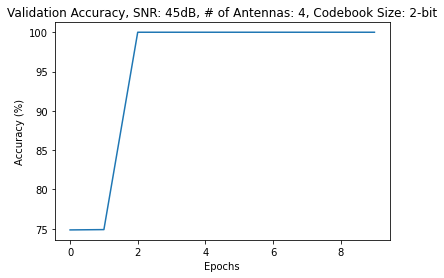

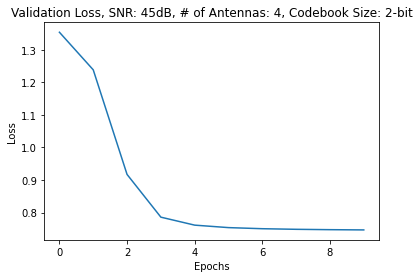

In [100]:
for SNR in range(len(SNR_dB)):
    for ant in range(len(num_ant)):
        for bit in range((len(bit_codebook))):
                plt.plot(validation_accuracy[SNR, ant, bit, :])
                plt.title(f'Validation Accuracy, SNR: {SNR_dB[SNR]}dB, # of Antennas: {num_ant[ant]}, Codebook Size: {bit_codebook[bit]}-bit')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy (%)')
                plt.show()

                plt.plot(validation_loss_buffer[SNR, ant, bit, :])
                plt.title(f'Validation Loss, SNR: {SNR_dB[SNR]}dB, # of Antennas: {num_ant[ant]}, Codebook Size: {bit_codebook[bit]}-bit')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.show()

In [24]:
for SNR in SNR_dB:
    for ant in num_ant:
        for bit in bit_codebook:
            print(f'======{SNR} dB, {ant} antennas, {bit} bit codebook======')
            
            precoders, labels = load_dataset('datasets', fading, ant, SNR, bit)
            if visual == 1:
                visualize(precoders)

            precoder_data = stack(precoders, axis=0)
            precoder_labels = array(labels)    

            precoder_dataset = PrecoderDataset(precoder_data, precoder_labels)
            train, val = random_split(precoder_dataset, [int(0.8*max_iter), int(0.2*max_iter)])
            train_loader = DataLoader(train, batch_size=128, shuffle=True, num_workers=0)
            val_loader = DataLoader(val, batch_size=128, shuffle=True, num_workers=0)
            
            num_classes = 2**bit
            nn_input_size = 2*ant*ant
            nn_output_size = num_classes
            
            model = Model(nn_input_size, nn_output_size)

            if torch.cuda.is_available():
                model.cuda()

            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            loss = nn.CrossEntropyLoss()
            for epoch in range(num_epochs):

                # TRAINING
                model.train()
                training_total_correct = 0
                training_losses = list()
                for batch in train_loader:

                    x, y = batch # extracted from the batch 

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    # step 1: forward pass 
                    prob = model(x) 

                    output = prob
                    target = y

                    # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
                    obj_func = loss(output, target)

                    # step 3: clear the gradients 
                    model.zero_grad()

                    # step 4: accumulate partial derivatives of obj_func wrt parameters 
                    obj_func.backward()

                    # step 5: step in the opposite direction of the gradient 
                    optimizer.step()

                    training_losses.append(obj_func.item())

                    max_prob, max_ind = torch.max(output, 1)
                    for ind in range(len(max_ind)):
                        if torch.equal(max_ind[ind], y[ind]):
                            training_total_correct += 1    

                # VALIDATION
                model.eval()

                validation_total_correct = 0
                validation_losses = list()
                for batch in val_loader:

                    x, y = batch # extracted from the batch 

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    # step 1: forward pass 
                    with torch.no_grad():
                        prob = model(x) 

                    output = prob
                    target = y

                    # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
                    obj_func = loss(output, target)
                    validation_losses.append(obj_func.item())

                    max_prob, max_ind = torch.max(output, 1)

                    for ind in range(len(max_ind)):
                        if torch.equal(max_ind[ind], y[ind]):
                            validation_total_correct += 1
                training_accuracy = (training_total_correct/len(train))*100  
                validation_accuracy = (validation_total_correct/len(val))*100   

                print(f'Epoch {epoch + 1}, training loss: {torch.tensor(training_losses).mean():.8f}, training accuracy: {training_accuracy}%, validation loss: {torch.tensor(validation_losses).mean():.8f}, validation accuracy: {validation_accuracy}%')

======10 dB, 2 antennas, 1 bit codebook======
datasets/1_precoder_data_2_ant_SNR_10dB_1_bit_codebk
Epoch 1, training loss: 0.59856826, training accuracy: 89.3675%, validation loss: 0.47822833, validation accuracy: 93.315%


C:\Users\bup48\anaconda3\envs\Py37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


KeyboardInterrupt: 